In [1]:
# INTEL CORPORATION CONFIDENTIAL AND PROPRIETARY
# 
# Copyright © 2019-2021 Intel Corporation.
# 
# This software and the related documents are Intel copyrighted
# materials, and your use of them is governed by the express 
# license under which they were provided to you (License). Unless
# the License provides otherwise, you may not use, modify, copy, 
# publish, distribute, disclose or transmit  this software or the
# related documents without Intel's prior written permission.
# 
# This software and the related documents are provided as is, with
# no express or implied warranties, other than those that are 
# expressly stated in the License.

In [2]:
import nxsdk.api.n2a as nx
import matplotlib.pyplot as plt

# Neurons vs Compartments
In the NxSDK, a neuron consists of a soma, and optionally, a binary dendritic tree. A neuron with no dendritic tree is just a single-compartment neuron (just the soma) and is the same as the compartment used in most other tutorials. A compartment is therefore just a special case of a neuron, but a neuron can also consist of many compartments (a multi-compartment neuron).

![Neuron vs compartment](figures/jupyter_multicompartment_neuron_vs_compartment.png)

Just like interface for individual compartments, neurons are defined by first creating a neuron prototype. Thereafter, a single neuron, or group of neurons can be created from the neuron prototype in the same way that individual compartments are created from compartment prototypes.

## How to create a neuron
Below we show how to create a single-compartment neuron and that it behaves the same as a compartment.

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.36:36159
INFO:DRV:      Host server up..............Done 0.32s
INFO:DRV:      Encoding axons/synapses.....Done 1.18ms
INFO:HST:  Args chip=0 cpu=0 /home/gorchard/nxsdk-nxsdk/nxsdk/driver/../bin/arm/simple_snn.bin --chips=1 --remote-relay=0 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 10.04s
INFO:DRV:      Encoding probes.............Done 0.72ms
INFO:DRV:      Transferring probes.........Done 3.84ms
INFO:DRV:      Configuring registers.......Done 4.07ms
INFO:DRV:      Transferring spikes.........Done 0.44ms
INFO:DRV:      Executing...................Done 5.64ms
INFO:DRV:      Processing timeseries.......Done 6.36ms
INFO:DRV:  Executor: 50 timesteps..........Done 10.41s
INFO:HST:  chip=0 cpu=0 halted, status=0x0


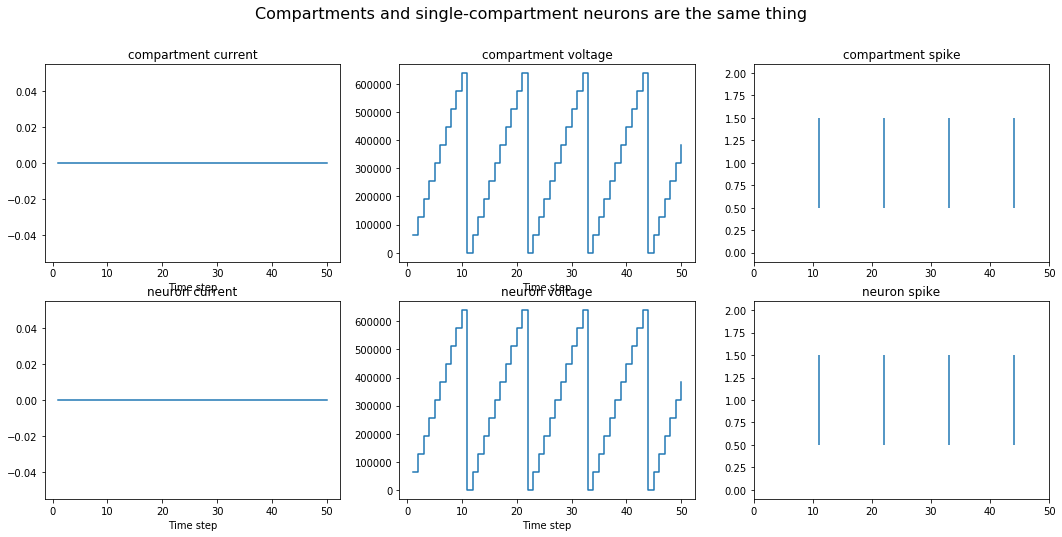

In [3]:
net = nx.NxNet()

# create a compartment prototype
compartmentProto = nx.CompartmentPrototype(biasMant=1000,
                                           biasExp=6,
                                           vThMant=10000,
                                           compartmentVoltageDecay=0,
                                           functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE)

# create a compartment
compartment = net.createCompartment(compartmentProto)


# create a neuron prototype from the compartment prototype
neuronProto = nx.NeuronPrototype(compartmentProto)

# create a neuron
neuron = net.createNeuron(neuronProto)

# probe the compartment and the neuron
(uProbes_c, vProbes_c, sProbes_c) = compartment.probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                                       nx.ProbeParameter.COMPARTMENT_VOLTAGE,                                                       
                                                       nx.ProbeParameter.SPIKE])

# note that we probe the neuron soma because the neuron can also optionally have dendrites
(uProbes_n, vProbes_n, sProbes_n) = neuron.soma.probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                                       nx.ProbeParameter.COMPARTMENT_VOLTAGE,                                                       
                                                       nx.ProbeParameter.SPIKE])

net.run(50)
net.disconnect()

# soma ignores d.V from dendrite and fires with its own bias
fig = plt.figure(1, figsize=(18,8))
fig.suptitle("Compartments and single-compartment neurons are the same thing", fontsize=16)
plt.subplot(2,3,1)
plt.title('compartment current')
uProbes_c.plot()
plt.subplot(2,3,2)
plt.title('compartment voltage')
vProbes_c.plot()
plt.subplot(2,3,3)
plt.title('compartment spike')
sProbes_c.plot()
plt.xlim([0,50])

plt.subplot(2,3,4)
plt.title('neuron current')
uProbes_n.plot()
plt.subplot(2,3,5)
plt.title('neuron voltage')
vProbes_n.plot()
plt.subplot(2,3,6)
plt.title('neuron spike')
sProbes_n.plot()
plt.xlim([0,50])
plt.show()

# Multi-compartment neurons
A multi-compartment neuron is a binary tree of compartments. Each node (compartment) in the tree can have up to two child nodes (also compartments), A and B. The root node is the soma compartment, and the child nodes are the dendritic compartments. When a compartment has two children, child A and its children cannot branch.

![branching ](figures/jupyter_multicompartment_tree.png)

## Push operations
The "Push" operation for a dendrite defines the output of that dendrite (the value it communicates to other compartments). A dendrite can push either its voltage (PUSH) or its current (PUSH_U). The default push operation for dendrites is PUSH_V.

## Join operations
The "Join" operation defines how a node (soma or dendrite) incorporates the input from its dendrites. This tutorial will walk through the different join operations and their behaviour.

### nomenclature

| symbol         | meaning              | 
|----------|---------------| 
| C | The parent node |
| A, B | The child nodes (dendrites) |
| C.S[t]   | whether C would produce a spike before the join op is considered (the join op can block the spike)|
| C.S'[t]  | whether C actually spikes at time t|
| X.V[t]   | voltage of compartment X, where X is either A, B, or C. If X spiked, X.V is the value before the reset (i.e. it will be greater than threshold)|
| X.U[t]   | current of compartment X, where X is either A, B, or C|
| X.U'[t]  | current of compartment X incorporating bias, ie. X.U'[t] = X.U[t] + X.bias |
| A[t] | The output of dendrite A at time t, which is either A.V[t] or A.U'[t] depending on the PUSH operation. A[t]=0 if there are no dendrites |
| B[t] | The output of dendrite B at time t, which is either B.V[t] or B.U'[t] depending on the PUSH operation. B[t]=0 if there are less than 2 dendrites |


### join operation summary
A compartment "C" updates as:

C.V[t] = C.V[t-1] \* (1-decay) + C.dV[t]

| join op         | effect on C | description |
|----------|---------------|------|
| SKIP | C.dV[t] = C.U'[t] | no effect | 
| ADD | C.dV[t] = C.dV[t] = C.U'[t] + A[t] + B[t] | C.dV includes the outputs from A and B |
| MAX | C.dV[t] = max(C.U'[t], A[t], B[t]) | C.dV takes on the largest value  |
| MIN | C.dV[t] = min(C.U'[t], A[t], B[t]) | C.dV takes on the smallest value |
| PASS | C.dV[t] = A.S[t] ? C.U'[t] + B : 0 | C.dV can only be non-zero when A spikes |
| BLOCK | C.dV[t] = A.S[t] ? 0 : C.U'[t] + B | C.dV can only be non-zero when A doesn't spike |
| OR | C.S'[t] = A.S[t] \| B.S[t] \| C.S[t] | C spikes when ever any of A, B, and C would have spiked |
| AND | C.S'[t] = A.S[t] & B.S[t] & C.S[t] | C spikes only if A, B, and C all would have spiked |


## Helper function for creating a multi-compartment neuron with a single dendrite
Below we create a multi-compartment neuron by adding a dendrite and show how to probe the soma and dendrite individually. We'll call this function with different join operations to investigate their behaviour. 

In [4]:
def testJoinOpSingleDendrite(joinOp, stackout, figName):
    net = nx.NxNet()

    # dendriteAProto is the single input (dendrite) to the soma (root node) 
    dendriteProto = nx.CompartmentPrototype(biasMant=500,
                                            biasExp=6,
                                            vThMant=10000,
                                            compartmentVoltageDecay=0,
                                            functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE,
                                            stackOut=stackout)

    # define soma prototype
    somaProto = nx.CompartmentPrototype(biasMant=250,
                                        biasExp=6,
                                        vThMant=130000,
                                        compartmentVoltageDecay=0,
                                        functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE)

    # create a multi-compartment neuron with single dendritic input
    # The single dendrite is always child A
    somaProto.addDendrite(dendriteProto, joinOp)
    neuronProto = nx.NeuronPrototype(somaProto)
    n = net.createNeuron(neuronProto)

    # here n.soma indexes the soma
    (uProbes_soma, vProbes_soma, sProbes_soma) = n.soma.probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                                               nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                                               nx.ProbeParameter.SPIKE])

    print(n.dendrites)
    # here n.dendrites[0] indexes the dendrite
    (uProbes_dendrite, vProbes_dendrite, sProbes_dendrite) = n.dendrites[0].probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                                                                   nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                                                                   nx.ProbeParameter.SPIKE])

    net.run(50)
    net.disconnect()

    # soma ignores d.V from dendrite and fires with its own bias
    fig = plt.figure(1, figsize=(18,8))
    fig.suptitle(figName, fontsize=16)
    plt.subplot(2,3,1)
    plt.title('dendrite current')
    uProbes_dendrite.plot()
    plt.subplot(2,3,2)
    plt.title('dendrite voltage')
    vProbes_dendrite.plot()
    plt.subplot(2,3,3)
    plt.title('dendrite spike')
    sProbes_dendrite.plot()
    plt.xlim([0,50])

    plt.subplot(2,3,4)
    plt.title('soma current')
    uProbes_soma.plot()
    plt.subplot(2,3,5)
    plt.title('soma voltage')
    vProbes_soma.plot()
    plt.subplot(2,3,6)
    plt.title('soma spike')
    sProbes_soma.plot()
    plt.xlim([0,50])
    
    plt.show()

## SKIP operation
In this case, the soma uses the SKIP join operation, which means that the soma does not use the dendrite output. i.e. C.dV[t] = C.U[t] + C.bias, which is the same as a single compartment neuron.

This example therefore shows the baseline behaviour of the dendrite and soma as if they were not connected. Later examples will show how the behaviour changes for different join operations.

In the baseline example, the voltage of both compartments increases linearly.

(<nxsdk.net.nodes.compartments.Compartment object at 0x7f6a14f7e7f0>,)
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.36:41543
INFO:DRV:      Host server up..............Done 0.18s
INFO:DRV:      Encoding axons/synapses.....Done 1.10ms
INFO:HST:  Args chip=0 cpu=0 /home/gorchard/nxsdk-nxsdk/nxsdk/driver/../bin/arm/simple_snn.bin --chips=1 --remote-relay=0 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 10.04s
INFO:DRV:      Encoding probes.............Done 0.66ms
INFO:DRV:      Transferring spikes.........Done 0.52ms
INFO:DRV:      Configuring registers.......Done 4.89ms
INFO:DRV:      Transferring probes.........Done 3.60ms
INFO:DRV:      Executing...................Done 6.92ms
INFO:DRV:      Processing timeseries.......Done 6.12ms
INFO:DRV:  Executor: 50 timesteps..........Done 10.26s
INFO:HST:  chip=0 cpu=0 halted, status=0x0


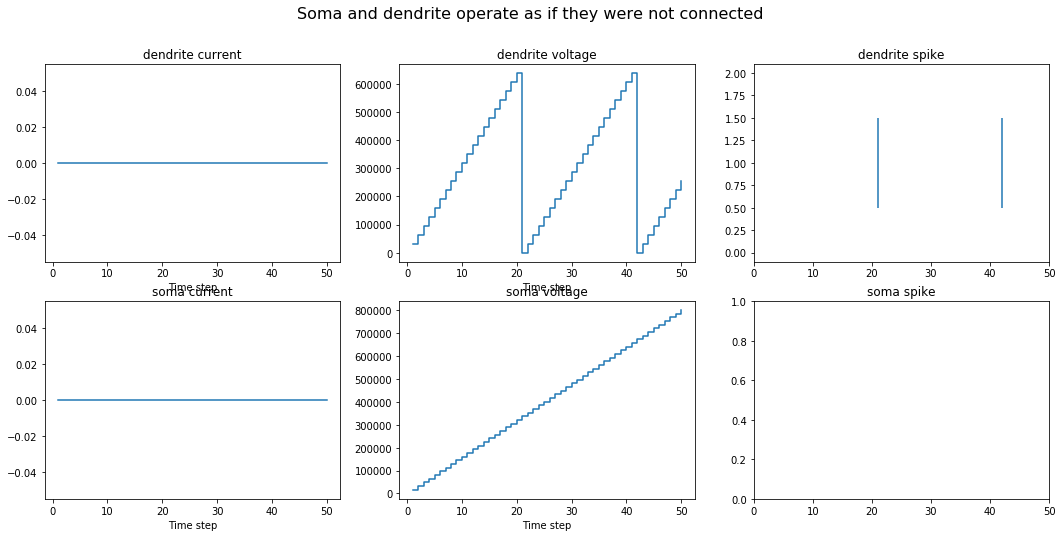

In [5]:
testJoinOpSingleDendrite(nx.COMPARTMENT_JOIN_OPERATION.SKIP, nx.COMPARTMENT_OUTPUT_MODE.SKIP, "SKIP: Soma and dendrite behave as if they were not connected")

### MAX join operation with single dendritic compartment
For MAX operation: C.dV[t] = max(C.U'[t], A[t], B[t]) <br>
In the cell below: 
- There is only one input, A, so B[t]=0 
- A uses the default PUSH_V operation, therefore A[t]=A.V[t]
- C.U[t] = 0, so C.U'[t] = C.bias
- therefore C.dV[t] = max(C.bias, A.V[t], 0)  
- A.V[t] is always bigger than C.bias
- therefore C.dV[t] = A.V[t]

The soma voltage now increases faster than the baseline case, and the rate increases as the dendrite voltage increases.

(<nxsdk.net.nodes.compartments.Compartment object at 0x7f6a140564e0>,)
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.36:36473
INFO:DRV:      Host server up..............Done 0.19s
INFO:DRV:      Encoding axons/synapses.....Done 2.10ms
INFO:DRV:      Encoding probes.............Done 0.92ms
INFO:HST:  Args chip=0 cpu=0 /home/gorchard/nxsdk-nxsdk/nxsdk/driver/../bin/arm/simple_snn.bin --chips=1 --remote-relay=0 --epoch=0 
INFO:DRV:      Booting up..................Done 10.04s
INFO:DRV:      Transferring probes.........Done 4.00ms
INFO:DRV:      Configuring registers.......Done 5.22ms
INFO:DRV:      Transferring spikes.........Done 0.61ms
INFO:HST:  Lakemont_driver...
INFO:DRV:      Executing...................Done 6.91ms
INFO:DRV:      Processing timeseries.......Done 5.60ms
INFO:DRV:  Executor: 50 timesteps..........Done 10.28s
INFO:HST:  chip=0 cpu=0 halted, status=0x0


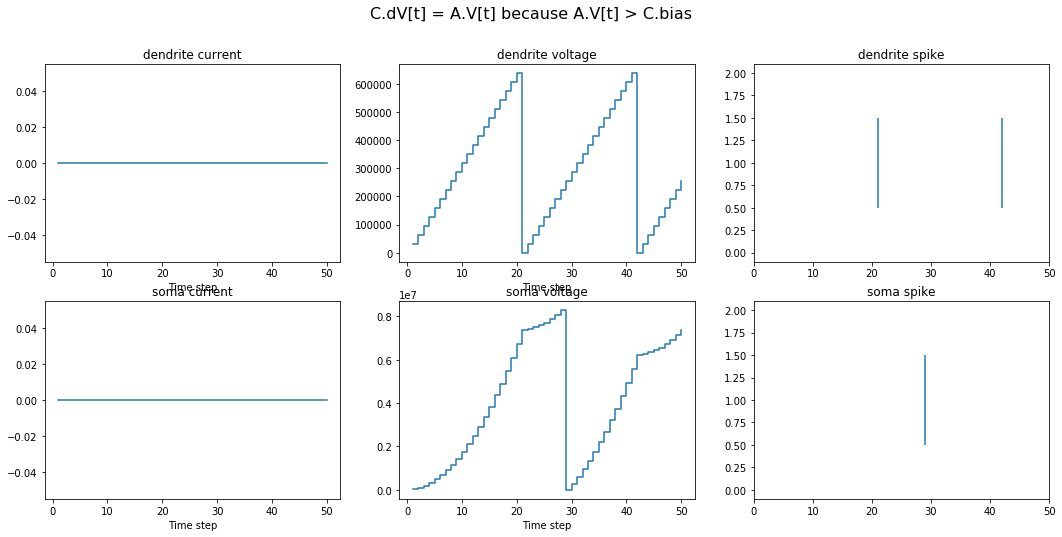

In [6]:
testJoinOpSingleDendrite(nx.COMPARTMENT_JOIN_OPERATION.MAX, nx.COMPARTMENT_OUTPUT_MODE.PUSH, "MAX: C.dV[t] = A.V[t] because A.V[t] > C.bias")

### Dendrite outputting current instead of voltage
##### Still using MAX join operation with single dendritic compartment
For MAX operation: C.dV[t] = max(C.U'[t], A[t], B[t]) <br>
In the cell below: 
- There is only one input, A, so B[t]=0 
- A uses the PUSH_U operation, therefore A[t]=A.U'[t]
- A.U[t] = 0, so A.U'[t] = A.bias
- C.U[t] = 0, so C.U'[t] = C.bias
- therefore C.dV[t] = max(C.bias, A.bias, 0)  
- A.bias is bigger than C.bias
- therefore C.dV[t] = A.bias

The soma voltage increases faster than the baseline case (notice the scale on the y-axis), but it increases linearly

(<nxsdk.net.nodes.compartments.Compartment object at 0x7f6a14c981d0>,)
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.36:32919
INFO:DRV:      Host server up..............Done 0.25s
INFO:DRV:      Encoding axons/synapses.....Done 0.98ms
INFO:DRV:      Encoding probes.............Done 0.85ms
INFO:HST:  Args chip=0 cpu=0 /home/gorchard/nxsdk-nxsdk/nxsdk/driver/../bin/arm/simple_snn.bin --chips=1 --remote-relay=0 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 10.05s
INFO:DRV:      Transferring probes.........Done 4.16ms
INFO:DRV:      Configuring registers.......Done 3.62ms
INFO:DRV:      Transferring spikes.........Done 0.54ms
INFO:DRV:      Executing...................Done 7.19ms
INFO:DRV:      Processing timeseries.......Done 5.88ms
INFO:DRV:  Executor: 50 timesteps..........Done 10.34s
INFO:HST:  chip=0 cpu=0 halted, status=0x0


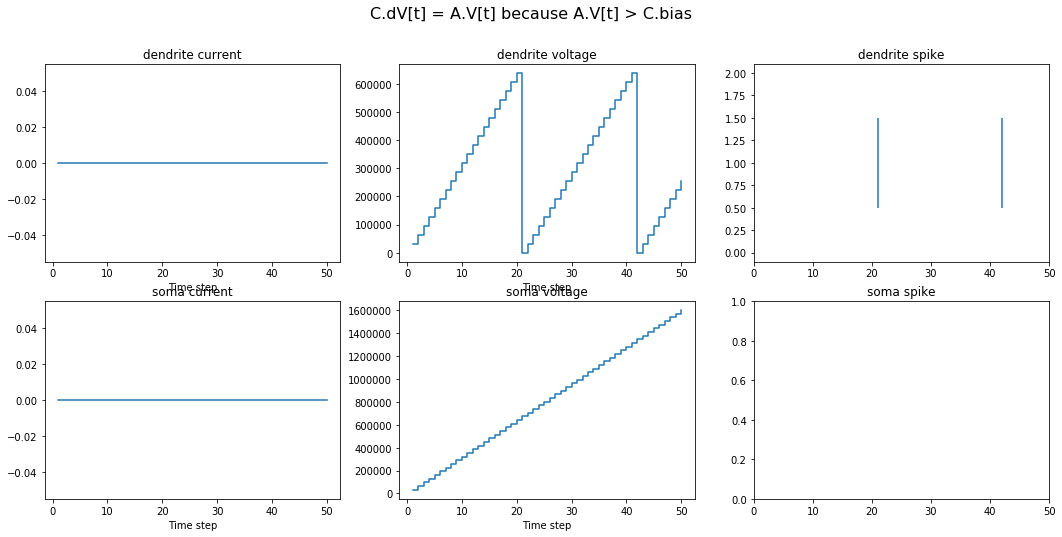

In [7]:
testJoinOpSingleDendrite(nx.COMPARTMENT_JOIN_OPERATION.MAX, nx.COMPARTMENT_OUTPUT_MODE.PUSH_U, "MAX with PUSH_Y: C.dV[t] = A.bias")

### ADD operation with single dendritic compartment
For ADD operation: C.dV[t] = C.U'[t] + A[t] + B[t] <br>
In the cell below: 
- There is only one input, A, so B[t]=0 
- A uses the default PUSH operation, therefore A[t]=A.V[t]
- C.U[t] = 0, so C.U'[t] = C.bias
- therefore C.dV[t] = A.V[t] + C.bias
Thus the only difference from the previous case is the inclusion of the C.bias term, which makes a small but noticeable difference below.

(<nxsdk.net.nodes.compartments.Compartment object at 0x7f6a14da4550>,)
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.36:33985
INFO:DRV:      Host server up..............Done 0.18s
INFO:DRV:      Encoding axons/synapses.....Done 1.52ms
INFO:DRV:      Encoding probes.............Done 0.64ms
INFO:HST:  Args chip=0 cpu=0 /home/gorchard/nxsdk-nxsdk/nxsdk/driver/../bin/arm/simple_snn.bin --chips=1 --remote-relay=0 --epoch=0 
INFO:DRV:      Booting up..................Done 10.04s
INFO:DRV:      Transferring probes.........Done 3.72ms
INFO:DRV:      Transferring spikes.........Done 0.54ms
INFO:DRV:      Configuring registers.......Done 4.12ms
INFO:HST:  Lakemont_driver...
INFO:DRV:      Executing...................Done 6.94ms
INFO:DRV:      Processing timeseries.......Done 6.08ms
INFO:DRV:  Executor: 50 timesteps..........Done 10.27s
INFO:HST:  chip=0 cpu=0 halted, status=0x0


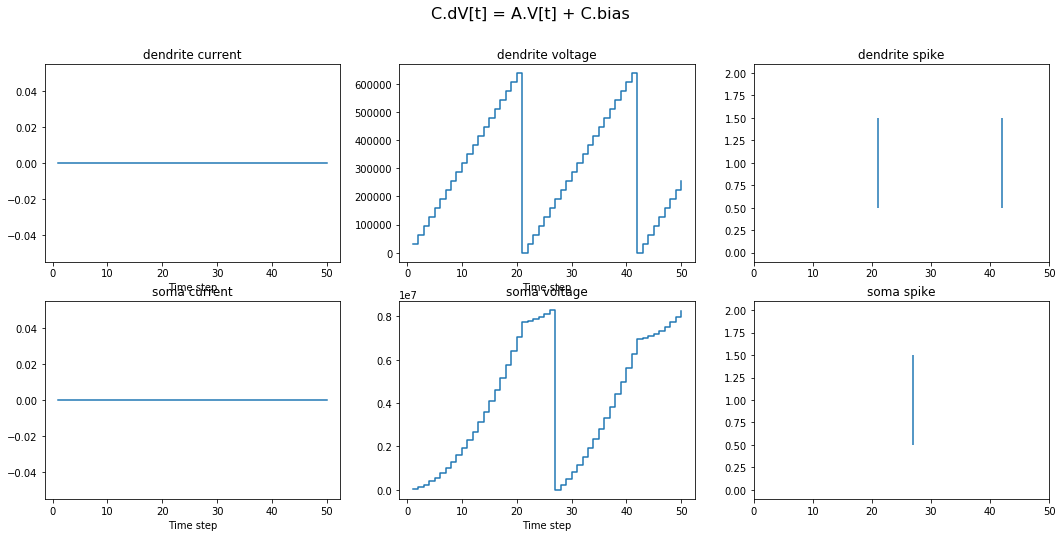

In [8]:
testJoinOpSingleDendrite(nx.COMPARTMENT_JOIN_OPERATION.ADD, nx.COMPARTMENT_OUTPUT_MODE.PUSH, "ADD: C.dV[t] = A.V[t] + C.bias")

## Join operation with two dendritic compartments
In this section, we demonstrate the join operations for a compartment with two dendrites. The addDendrites() function is used to define the join operation with the two child inputs.

We first define a similar helping function

In [9]:
def testJoinOpTwoDendrites(joinOp, figName):
    net = nx.NxNet()

    dendriteAProto = nx.CompartmentPrototype(biasMant=500,
                                             biasExp=6,
                                             vThMant=10000,
                                             compartmentVoltageDecay=0,
                                             functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE)
    
    dendriteBProto = nx.CompartmentPrototype(biasMant=250,
                                             biasExp=6,
                                             vThMant=10000,
                                             compartmentVoltageDecay=0,
                                             functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE)

    # define soma prototype
    somaProto = nx.CompartmentPrototype(biasMant=125,
                                        biasExp=6,
                                        vThMant=100000,
                                        compartmentVoltageDecay=0,
                                        functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE)

    # create a multi-compartment neuron with single dendritic input
    # The first prototype is child A, the second is child B
    somaProto.addDendrites(dendriteAProto, dendriteBProto, joinOp)
    neuronProto = nx.NeuronPrototype(somaProto)
    n = net.createNeuron(neuronProto)

    # here n.soma indexes the soma
    (uProbes_soma, vProbes_soma, sProbes_soma) = n.soma.probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                                               nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                                               nx.ProbeParameter.SPIKE])

    # here n.dendrites[0] indexes the dendriteA
    (uProbes_dendriteA, vProbes_dendriteA, sProbes_dendriteA) = n.dendrites[0].probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                                                                   nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                                                                   nx.ProbeParameter.SPIKE])
    # here n.dendrites[1] indexes the dendriteB
    (uProbes_dendriteB, vProbes_dendriteB, sProbes_dendriteB) = n.dendrites[1].probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                                                                   nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                                                                   nx.ProbeParameter.SPIKE])

    net.run(50)
    net.disconnect()

    # soma ignores d.V from dendrite and fires with its own bias
    fig = plt.figure(1, figsize=(18,8))
    fig.suptitle(figName, fontsize=16)
    plt.subplot(3,3,1)
    plt.title('dendrite A current')
    uProbes_dendriteA.plot()
    plt.subplot(3,3,2)
    plt.title('dendrite A voltage')
    vProbes_dendriteA.plot()
    plt.subplot(3,3,3)
    plt.title('dendrite A spike')
    sProbes_dendriteA.plot()
    plt.xlim([0,50])

    plt.subplot(3,3,4)
    plt.title('dendrite B current')
    uProbes_dendriteB.plot()
    plt.subplot(3,3,5)
    plt.title('dendrite B voltage')
    vProbes_dendriteB.plot()
    plt.subplot(3,3,6)
    plt.title('dendrite B spike')
    sProbes_dendriteB.plot()
    plt.xlim([0,50])
    
    plt.subplot(3,3,7)
    plt.title('soma current')
    uProbes_soma.plot()
    plt.subplot(3,3,8)
    plt.title('soma voltage')
    vProbes_soma.plot()
    plt.subplot(3,3,9)
    plt.title('soma spike')
    sProbes_soma.plot()
    plt.xlim([0,50])
    
    plt.show()

### Add operation with two dendritic compartments
For ADD operation: <br>
    C.dV[t] = C.U'[t] + A[t] + B.V[t] <br>
In the cell below:
- A and B use the default PUSH_V operation, therefore A[t]=A.V[t] and B[t]=B.V[t]
- C.U[t] = 0, so C.U'[t] = C.bias
- therefore C.dV[t] = A.V[t] + B.V[t] + C.bias
Note that the threshold for compartment C is much higher than for A and B

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.36:33907
INFO:DRV:      Host server up..............Done 0.18s
INFO:DRV:      Encoding axons/synapses.....Done 1.57ms
INFO:HST:  Args chip=0 cpu=0 /home/gorchard/nxsdk-nxsdk/nxsdk/driver/../bin/arm/simple_snn.bin --chips=1 --remote-relay=0 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 10.04s
INFO:DRV:      Encoding probes.............Done 0.93ms
INFO:DRV:      Transferring probes.........Done 3.71ms
INFO:DRV:      Configuring registers.......Done 3.88ms
INFO:DRV:      Transferring spikes.........Done 0.67ms
INFO:DRV:      Executing...................Done 6.13ms
INFO:DRV:      Processing timeseries.......Done 7.37ms
INFO:DRV:  Executor: 50 timesteps..........Done 10.27s
INFO:HST:  chip=0 cpu=0 halted, status=0x0


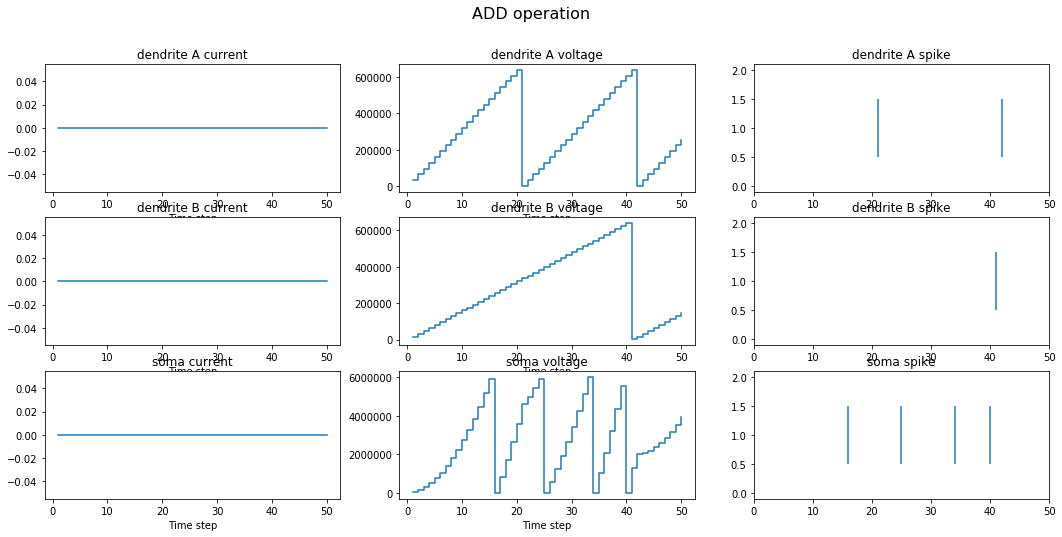

In [10]:
testJoinOpTwoDendrites(nx.COMPARTMENT_JOIN_OPERATION.ADD, "ADD with 2 dendrites")

### MAX operation with two dendritic compartments
For MAX operation: <br> 
C.dV[t] = max(C.U'[t], A[t], B[t]) <br>

In the cell below:
- A and B use the default PUSH_V operation, therefore A[t]=A.V[t] and B[t]=B.V[t]
- C.U[t] = 0, so C.U'[t] = C.bias
- A.V and B.V are always greater than C.bias
- therefore C.dV[t] = max(A.V[t] + B.V[t])

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.36:45831
INFO:DRV:      Host server up..............Done 0.18s
INFO:DRV:      Encoding axons/synapses.....Done 1.11ms
INFO:HST:  Args chip=0 cpu=0 /home/gorchard/nxsdk-nxsdk/nxsdk/driver/../bin/arm/simple_snn.bin --chips=1 --remote-relay=0 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 10.04s
INFO:DRV:      Encoding probes.............Done 0.59ms
INFO:DRV:      Configuring registers.......Done 4.03ms
INFO:DRV:      Transferring spikes.........Done 0.52ms
INFO:DRV:      Transferring probes.........Done 4.05ms
INFO:DRV:      Executing...................Done 6.34ms
INFO:DRV:      Processing timeseries.......Done 7.67ms
INFO:DRV:  Executor: 50 timesteps..........Done 10.27s
INFO:HST:  chip=0 cpu=0 halted, status=0x0


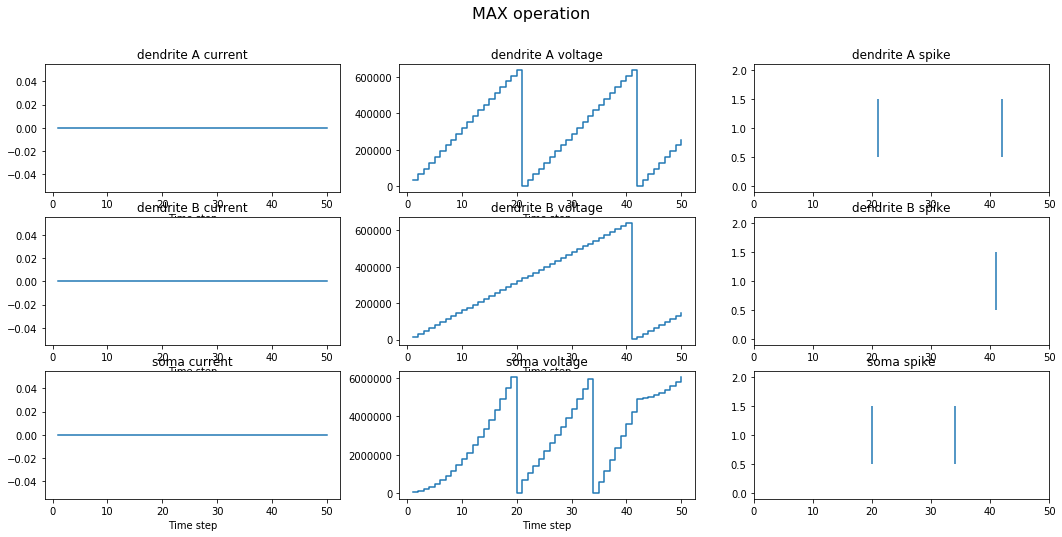

In [11]:
testJoinOpTwoDendrites(nx.COMPARTMENT_JOIN_OPERATION.MAX, "MAX with 2 dendrites")

### PASS operation with two dendritic compartments
For PASS operation: <br>
C.dV[t] = A.S[t]? C.U'[t] + B[t] : 0 <br>
In the cell below: <br>
- B uses the default PUSH_V, so B[t] = B.V[t]
- C.U = 0, so C.U'[t] = C.bias
- When A spikes, C.dV[t] = C.bias + B.V[t]
- When A doesn't spike, C.dV[t] = 0

The first time A spikes, B.V[t] is large, so C.dV[t] is large, causing a large increase in C.V <br>
The second time A spikes, B.V[t] is small, so C.dV[t] is small, causing a only a small increase in C.V  <br>
The rest of the time, C.dV[t] is zero, so C.V[t]=C.V[t-1]

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.36:44481
INFO:DRV:      Host server up..............Done 0.18s
INFO:DRV:      Encoding axons/synapses.....Done 1.55ms
INFO:HST:  Args chip=0 cpu=0 /home/gorchard/nxsdk-nxsdk/nxsdk/driver/../bin/arm/simple_snn.bin --chips=1 --remote-relay=0 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 10.05s
INFO:DRV:      Encoding probes.............Done 0.80ms
INFO:DRV:      Transferring spikes.........Done 0.71ms
INFO:DRV:      Transferring probes.........Done 3.68ms
INFO:DRV:      Configuring registers.......Done 4.72ms
INFO:DRV:      Executing...................Done 7.51ms
INFO:DRV:      Processing timeseries.......Done 6.43ms
INFO:DRV:  Executor: 50 timesteps..........Done 10.27s
INFO:HST:  chip=0 cpu=0 halted, status=0x0


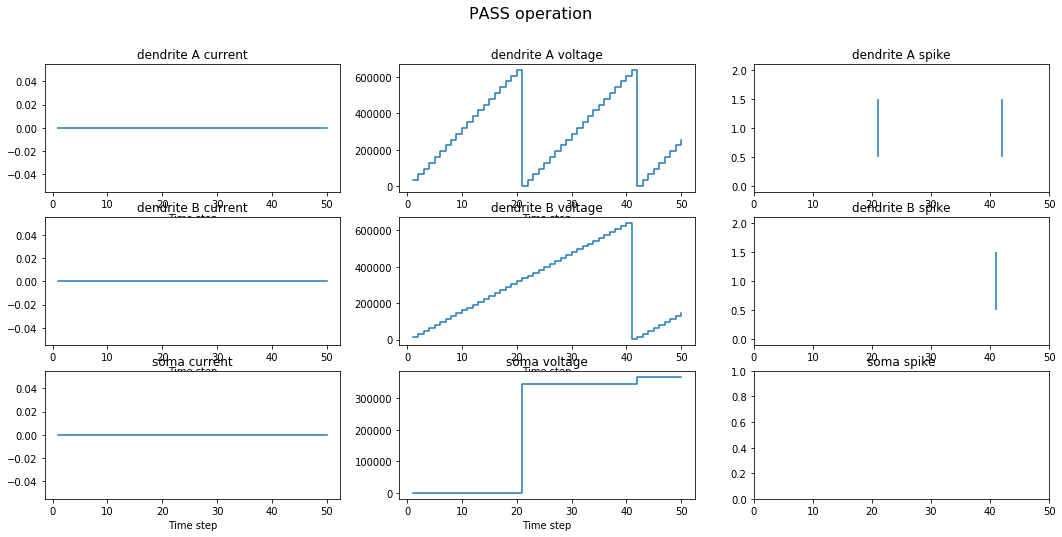

In [12]:
testJoinOpTwoDendrites(nx.COMPARTMENT_JOIN_OPERATION.PASS, "PASS with 2 dendrites")

### OR operation with two dendritic compartments
For OR operation: <br> 
C.S'[t] = A.S[t] | B.S [t] | C.S[t] <br>
C spikes whenever any of A, B, or C produces a spike

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.36:34249
INFO:DRV:      Host server up..............Done 0.19s
INFO:DRV:      Encoding axons/synapses.....Done 1.27ms
INFO:DRV:      Encoding probes.............Done 0.67ms
INFO:HST:  Args chip=0 cpu=0 /home/gorchard/nxsdk-nxsdk/nxsdk/driver/../bin/arm/simple_snn.bin --chips=1 --remote-relay=0 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 10.05s
INFO:DRV:      Transferring spikes.........Done 1.02ms
INFO:DRV:      Transferring probes.........Done 3.84ms
INFO:DRV:      Configuring registers.......Done 3.67ms
INFO:DRV:      Executing...................Done 7.38ms
INFO:DRV:      Processing timeseries.......Done 6.62ms
INFO:DRV:  Executor: 50 timesteps..........Done 10.28s
INFO:HST:  chip=0 cpu=0 halted, status=0x0


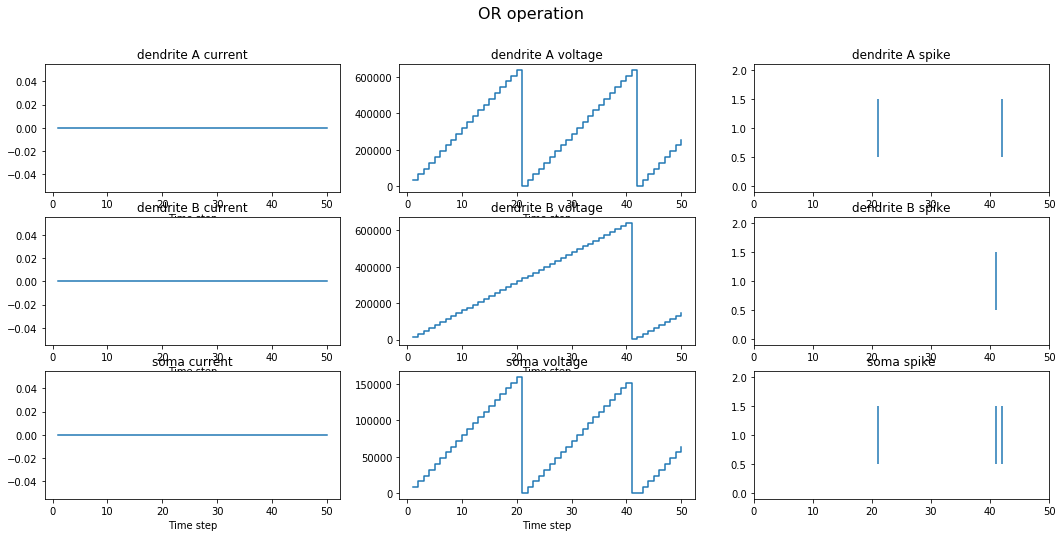

In [13]:
testJoinOpTwoDendrites(nx.COMPARTMENT_JOIN_OPERATION.OR, "OR with 2 dendrites")

### AND operation with two dendritic compartments
For AND operation: <br> 
C.S'[t] = A.S[t] | B.S [t] | C.S[t] <br>
C spikes only when A, B, and C would all spike together. Testing this requires careful configuration, so we do it in a custom manner below

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.36:38879
INFO:DRV:      Host server up..............Done 0.15s
INFO:DRV:      Encoding axons/synapses.....Done 1.15ms
INFO:HST:  Args chip=0 cpu=0 /home/gorchard/nxsdk-nxsdk/nxsdk/driver/../bin/arm/simple_snn.bin --chips=1 --remote-relay=0 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 10.05s
INFO:DRV:      Encoding probes.............Done 0.66ms
INFO:DRV:      Configuring registers.......Done 4.35ms
INFO:DRV:      Transferring spikes.........Done 0.63ms
INFO:DRV:      Transferring probes.........Done 3.64ms
INFO:DRV:      Executing...................Done 6.17ms
INFO:DRV:      Processing timeseries.......Done 7.32ms
INFO:DRV:  Executor: 50 timesteps..........Done 10.24s
INFO:HST:  chip=0 cpu=0 halted, status=0x0


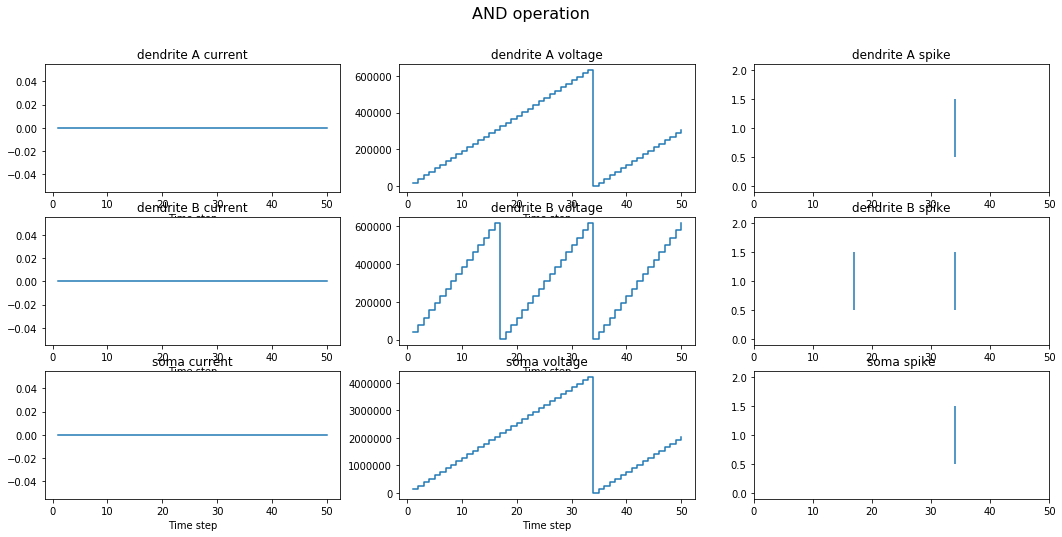

In [14]:
net = nx.NxNet()


dendriteAProto = nx.CompartmentPrototype(biasMant=300,
                                         biasExp=6,
                                         vThMant=10000,
                                         compartmentVoltageDecay=0,
                                         functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE)

dendriteBProto = nx.CompartmentPrototype(biasMant=600,
                                         biasExp=6,
                                         vThMant=10000,
                                         compartmentVoltageDecay=0,
                                         functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE)

# define soma prototype
somaProto = nx.CompartmentPrototype(biasMant=2000,
                                    biasExp=6,
                                    vThMant=10000,
                                    compartmentVoltageDecay=0,
                                    functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE)

# create a multi-compartment neuron with single dendritic input  
somaProto.addDendrites(dendriteAProto, dendriteBProto, nx.COMPARTMENT_JOIN_OPERATION.AND)
neuronProto = nx.NeuronPrototype(somaProto)
n = net.createNeuron(neuronProto)

# here n.soma indexes the soma
(uProbes_soma, vProbes_soma, sProbes_soma) = n.soma.probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                                           nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                                           nx.ProbeParameter.SPIKE])

# here n.dendrites[0] indexes the dendriteA
(uProbes_dendriteA, vProbes_dendriteA, sProbes_dendriteA) = n.dendrites[0].probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                                                               nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                                                               nx.ProbeParameter.SPIKE])
# here n.dendrites[1] indexes the dendriteB
(uProbes_dendriteB, vProbes_dendriteB, sProbes_dendriteB) = n.dendrites[1].probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                                                               nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                                                               nx.ProbeParameter.SPIKE])

net.run(50)
net.disconnect()


fig = plt.figure(1, figsize=(18,8))
fig.suptitle("AND with 2 dendrites", fontsize=16)
plt.subplot(3,3,1)
plt.title('dendrite A current')
uProbes_dendriteA.plot()
plt.subplot(3,3,2)
plt.title('dendrite A voltage')
vProbes_dendriteA.plot()
plt.subplot(3,3,3)
plt.title('dendrite A spike')
sProbes_dendriteA.plot()
plt.xlim([0,50])

plt.subplot(3,3,4)
plt.title('dendrite B current')
uProbes_dendriteB.plot()
plt.subplot(3,3,5)
plt.title('dendrite B voltage')
vProbes_dendriteB.plot()
plt.subplot(3,3,6)
plt.title('dendrite B spike')
sProbes_dendriteB.plot()
plt.xlim([0,50])

plt.subplot(3,3,7)
plt.title('soma current')
uProbes_soma.plot()
plt.subplot(3,3,8)
plt.title('soma voltage')
vProbes_soma.plot()
plt.subplot(3,3,9)
plt.title('soma spike')
sProbes_soma.plot()
plt.xlim([0,50])

plt.show()

Notice that C exceeds threshold at the same time as B, but C doesn't spike and reset because it requires A to also spike at the same time. C's voltage continues increasing above threshold until A and B both spike simultaneously. This satisfies the condition that A and B spiked, and C would have spiked (is above threshold) if not prevented from doing so by the join op.

## Building a deeper dendritic tree
Building a deeper dendritic tree just requires adding dendrites to dendrites. The example below shows how this can be done, and how to index dendrites deeper in the tree. 

Each compartment integrates its input, and passes it onto the next compartment, so we see each compartment's voltage increase faster than the previous compartment.

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.36:46857
INFO:DRV:      Host server up..............Done 0.18s
INFO:DRV:      Encoding axons/synapses.....Done 1.14ms
INFO:DRV:      Encoding probes.............Done 0.83ms
INFO:HST:  Args chip=0 cpu=0 /home/gorchard/nxsdk-nxsdk/nxsdk/driver/../bin/arm/simple_snn.bin --chips=1 --remote-relay=0 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 10.05s
INFO:DRV:      Transferring probes.........Done 3.89ms
INFO:DRV:      Configuring registers.......Done 3.75ms
INFO:DRV:      Transferring spikes.........Done 0.60ms
INFO:DRV:      Executing...................Done 8.27ms
INFO:DRV:      Processing timeseries.......Done 7.11ms
INFO:DRV:  Executor: 50 timesteps..........Done 10.27s
INFO:HST:  chip=0 cpu=0 halted, status=0x0


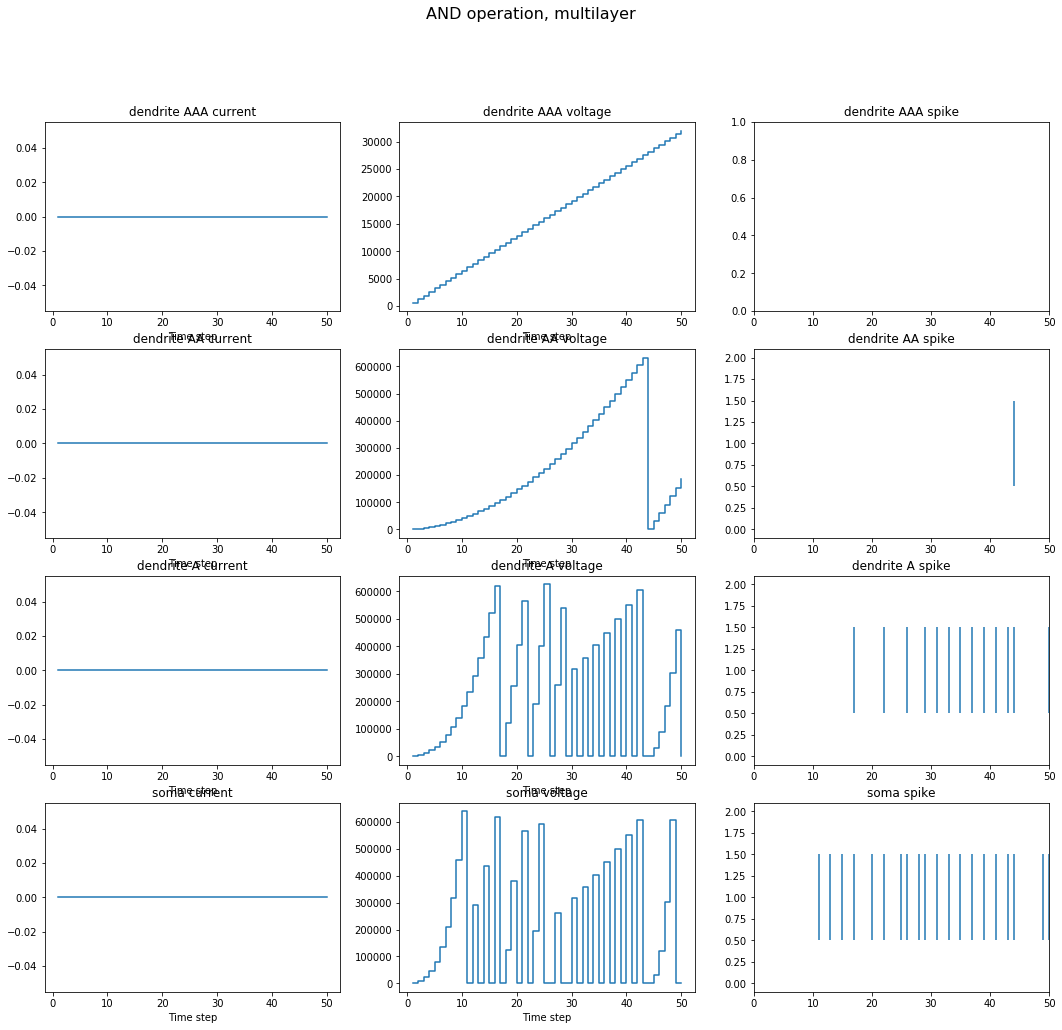

In [15]:
net = nx.NxNet()

dendriteAProto = nx.CompartmentPrototype(biasMant=10,
                                         biasExp=6,
                                         vThMant=10000,
                                         compartmentVoltageDecay=0,
                                         functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE)

dendriteAAProto = nx.CompartmentPrototype(biasMant=10,
                                          biasExp=6,
                                          vThMant=10000,
                                          compartmentVoltageDecay=0,
                                          functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE)

dendriteAAAProto = nx.CompartmentPrototype(biasMant=10,
                                           biasExp=6,
                                           vThMant=10000,
                                           compartmentVoltageDecay=0,
                                           functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE)


# define soma prototype
somaProto = nx.CompartmentPrototype(biasMant=10,
                                    biasExp=6,
                                    vThMant=10000,
                                    compartmentVoltageDecay=0,
                                    functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE)


# create a multi-compartment neuron with single dendritic input  
somaProto.addDendrite(dendriteAProto, nx.COMPARTMENT_JOIN_OPERATION.ADD)
dendriteAProto.addDendrite(dendriteAAProto, nx.COMPARTMENT_JOIN_OPERATION.ADD)
dendriteAAProto.addDendrite(dendriteAAAProto, nx.COMPARTMENT_JOIN_OPERATION.ADD)

neuronProto = nx.NeuronPrototype(somaProto)
n = net.createNeuron(neuronProto)

# here n.soma indexes the soma
(uProbes_soma, vProbes_soma, sProbes_soma) = n.soma.probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                                           nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                                           nx.ProbeParameter.SPIKE])

# n.dendrites[0] indexes the dendriteA
(uProbes_dendriteA, vProbes_dendriteA, sProbes_dendriteA) = n.dendrites[0].probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                                                                  nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                                                                  nx.ProbeParameter.SPIKE])
# n.dendrites[0].dendrites[0] is dendriteAA
(uProbes_dendriteAA, vProbes_dendriteAA, sProbes_dendriteAA) = n.dendrites[0].dendrites[0].probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                                                                                  nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                                                                                  nx.ProbeParameter.SPIKE])
# n.dendrites[0].dendrites[0].dendrites[0] is dendriteAAA
(uProbes_dendriteAAA, vProbes_dendriteAAA, sProbes_dendriteAAA) = n.dendrites[0].dendrites[0].dendrites[0].probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                                                                                                  nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                                                                                                  nx.ProbeParameter.SPIKE])

net.run(50)
net.disconnect()

fig = plt.figure(1, figsize=(18,16))
fig.suptitle("ADD operation, multilayer", fontsize=16)
plt.subplot(4,3,1)
plt.title('dendrite AAA current')
uProbes_dendriteAAA.plot()
plt.subplot(4,3,2)
plt.title('dendrite AAA voltage')
vProbes_dendriteAAA.plot()
plt.subplot(4,3,3)
plt.title('dendrite AAA spike')
sProbes_dendriteAAA.plot()
plt.xlim([0,50])

plt.subplot(4,3,4)
plt.title('dendrite AA current')
uProbes_dendriteAA.plot()
plt.subplot(4,3,5)
plt.title('dendrite AA voltage')
vProbes_dendriteAA.plot()
plt.subplot(4,3,6)
plt.title('dendrite AA spike')
sProbes_dendriteAA.plot()
plt.xlim([0,50])

plt.subplot(4,3,7)
plt.title('dendrite A current')
uProbes_dendriteA.plot()
plt.subplot(4,3,8)
plt.title('dendrite A voltage')
vProbes_dendriteA.plot()
plt.subplot(4,3,9)
plt.title('dendrite A spike')
sProbes_dendriteA.plot()
plt.xlim([0,50])

plt.subplot(4,3,10)
plt.title('soma current')
uProbes_soma.plot()
plt.subplot(4,3,11)
plt.title('soma voltage')
vProbes_soma.plot()
plt.subplot(4,3,12)
plt.title('soma spike')
sProbes_soma.plot()
plt.xlim([0,50])

plt.show()